## **[Week14] Generative Adversarial Network**

## **Table of Contents**

+ Task 1: Implement and train **Vanilla GAN** for **MNIST data generation**

    (1) Generator module\
    (2) Discriminator module\
    (3) Loss Function and Optimizer\
    (4) Discriminator train function\
    (5) Generator train function\
    (6) GAN training 

+ Task 2: Implement and train **cGAN** for **MNIST data generation**

    (1) Generator module\
    (2) Discriminator module\
    (3) Loss Function and Optimizer\
    (4) Discriminator train function\
    (5) Generator train function\
    (6) cGAN training 

+ Task 3: Implement **VAE** for **undertanding role of VAE losses**

    (1) VAE with only Reconstruction loss\
    (2) VAE with Reconstruction loss and Regularization loss

+ (Optional) Task 4: Implement and train **cDCGAN** for **MNIST data generation**

    (1) Generator module\
    (2) Discriminator module\
    (3) Loss Function and Optimizer\
    (4) Discriminator train function\
    (5) Generator train function\
    (6) cDCGAN training 


## **Basic Introductions**
###**1. Understanding GAN**

(1) **Vanilla GAN**: GAN with the most basic fully connected layer\
(2) **cGAN**: conditional GAN can generate images of the class you want.


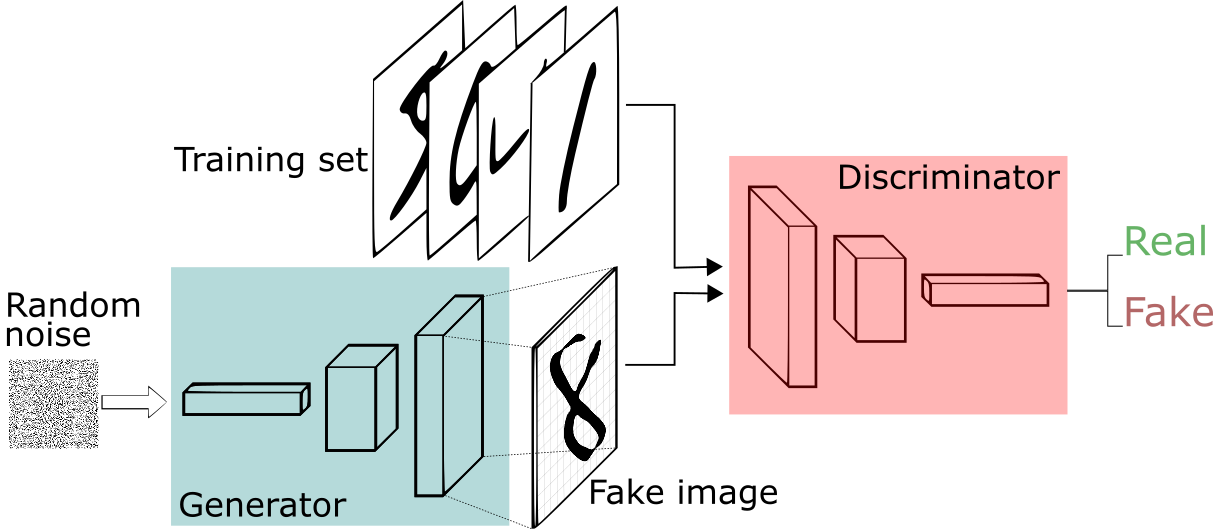

(3) **GAN (Generative adversarial network) structure**
- GAN consists of the generator and the discriminator which are adversarial.
- Generator and discriminator are trained to fight each other: generator tries to make generated images more real and discriminator tries to distinguish fake images from real ones.
- For example, consider a numerical image from 0 to 9 in the mnist dataset.

- **Generator**
    - Input: noise (z) of 100 dimensions
    - Output: fake digit images of the same size/format as the mnist image
    - Goal of train: training to produce images from noise that are more real.

- **Discriminator**
    - Input : digit image of mnist image size
    - Output: When the input is true image(real mnist image), output is 1.\
        When the input is fake image(generated image form generotor), output is 0.
    - Goal of train : Training to distinguish between real and fake images

- **Latent space**
    - The noise distribution space that can generate desired images is called a latent space.
    - Since the images are generated from random noise, we set dimension of noise as latent dimension.
    - In the case of MNIST, latent dimension is usually set to 100: The generator generates a fake images image by inputting a 100-dimensional noise.

In [ ]:
import argparse 
import os
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sn

# torchvision
import torchvision.transforms as transforms
from torchvision import datasets

# torch
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### **2. Hyperparameter Setting**

- Setting hyperparameters for MNIST dataset GAN training
- latent_dim = 100: set the dimension of Random noise z to 100.
- normal_init: define function for Network initialization.



In [ ]:
batch_size = 128                                   # size of the batches
img_size = 28                                      # size of each image dimension
n_channels = 1                                     # MNIST data number of image channels
n_classes = 10                                     # MNIST number of classes

latent_dim = 100                                   # dimensionality of the latent space

cuda = True if torch.cuda.is_available() else False
device = 'cuda:0' if cuda else 'cpu'

seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

###**3. Load dataset**
- MNIST dataset: a dataset consisting of 60000 hand-written digits as 28 * 28 pixel size and grayscale levels 
- Plotted random 10 images for reference

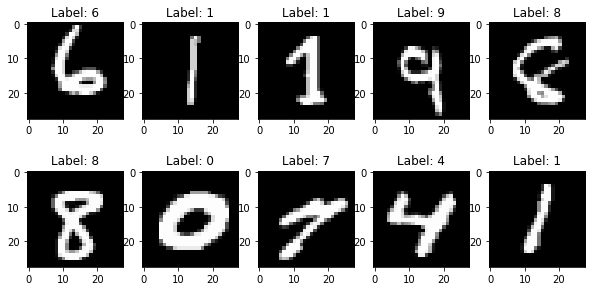

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),                            # Change data to Tensor
  transforms.Normalize(mean=(0.5,), std=(0.5,))     # pixel values 0 ~ 1 -> -1 ~ 1
])

mnist_train  = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

# Plot random MNIST data image
fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

examples = enumerate(train_loader)
_, (ex_data, ex_targets) = next(examples)

for i in range(10):
    ax = axes[i//5,i%5]
    ax.imshow(ex_data[i][0],cmap='gray')
    ax.set_title('Label: {}'.format(ex_targets[i]))

plt.show()


## **Task 1: MNIST image generation with Vanilla GAN**


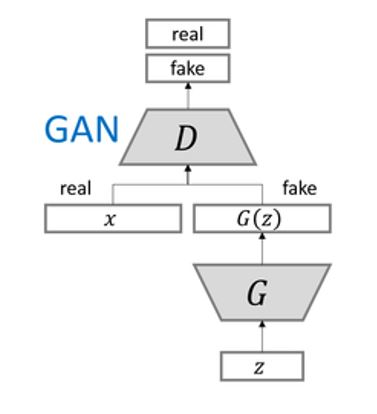

- Generator generates fake images from noise z.
- Discriminator distinguish real images and fake images, real images labeled to 1 and fake images labeled to 0.
- In vanilla GAN, all modules are composed of multiple fully connected layers.

### **1. Generator module**

- (100,) input to Full Connected Layer -> Create (784,) Output -> Reshape to (1,28,28)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                nn.BatchNorm1d(out_feat,)
                layers.append(nn.BatchNorm1d(out_feat, momentum=0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(n_channels*img_size*img_size)),
            nn.Tanh()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, z):
        img = self.model(z.view(z.size(0),-1))
        img = img.view(img.size(0), n_channels,img_size,img_size)
        return img


### **2. Discriminator module**
- (784,) input to Fully connected layer -> predict 0(fake) or 1(real)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(n_channels*img_size*img_size), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, img):
        out = self.model(img.view(img.size(0), -1))
        out = out.view(-1)
        return out

### **3. Loss Function and Optimizer**

- Define Generator abd Disciriminator model
- Define Loss function and set learning rate for training weight
- Implement Generator optimizer, Discriminator optimizer


In [ ]:
lr = 0.0002                                            # "adam: learning rate"

# Loss function
criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()
generator.weight_init(mean=0.0,std=0.02)
discriminator.weight_init(mean=0.0,std=0.02)

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

### **4. Discriminator train function**

- Function to calculate discriminator loss and update parameter during actual training.
- When the real image for training comes in, calculate loss by comparaing one with disciminator output (real loss)
- Create a fake image as z->G(z) and calculate loss by comparing zero with discriminator output (fake loss)
- total discriminator loss = real loss + fake loss
- While training discriminator, generator variables are fixed.

In [ ]:
def train_discriminator(discriminator, generator, images):
    d_optimizer.zero_grad()                                                      # initialize gradient to 0
    
    # train data/label to cuda
    real_images = images.to(device)                                              # real images
    real_labels_output = torch.ones(images.size(0)).to(device)                   # discriminator output of real images(=1)

    # train with real images
    real_validity = discriminator(real_images)                                   #putting the real images into the discriminator (real=1 or fake=0)
    real_loss = criterion(real_validity, real_labels_output)                     #calculate loss by comparing real_validity to real_labels_output (1)

    # generate fake images
    z = torch.randn(images.size(0), latent_dim).to(device)                       # generate noise
    fake_images = generator(z)                                                   # generate a fake image by inserting noise into the generator
    fake_labels_output =  torch.zeros(images.size(0)).to(device)                 # discriminator output of fake images(=0)

    # train with fake images
    fake_validity = discriminator(fake_images)                                   # putting the fake images into the discriminator
    fake_loss =  criterion(fake_validity, fake_labels_output)                    # calculate loss by comparing fake_validity to fake_labels_output (0)

    d_loss = real_loss + fake_loss                                               # descriminator loss is the sum of two losses
    d_loss.backward()                                                            # backpropagation
    d_optimizer.step()                                                           # parameter update

    return d_loss.item()

### **5. Generator train function**


- Implementing the function of calculating the generator loss and update parameter during the actual training process.
- Create a fake image with z->G(z) and test it with a discrimulator.
- Calculation of loss compared to 1 so that the discrimulator output is difficult to distinguish from the actual image output
- While training generator, discriminator variables are fixed.

In [ ]:
def train_generator(generator, discriminator, batch_size):
    g_optimizer.zero_grad()                                                      # initialize gradient to 0
    
    real_labels_output = torch.ones(batch_size).to(device)                       # discriminator output of real images(=1)

    # calculate fake validity
    z = torch.randn(batch_size, latent_dim).to(device)                           # generate noise
    fake_images = generator(z)                                                   # generate a fake image by inserting noise into the generator
    
    # compare discriminator output & real labels
    fake_validity = discriminator(fake_images)                                   # putting the fake images into the discriminator
    g_loss = criterion(fake_validity, real_labels_output)                        # calculate loss -> compare the output of discriminator from fake-image to the output(=1) from real-image

    g_loss.backward()                                                            # backpropagation
    g_optimizer.step()                                                           # parameter update

    return g_loss.item()

### **6. GAN training**
- Plot the test image to confirm the training result from GAN.

In [ ]:
def test_plot(num_test_samples,plot_axis,generator,latent_dim):
    (a,b) = plot_axis
    test_noise = torch.randn(num_test_samples, latent_dim).to(device)
    fig,axes = plt.subplots(b,a,figsize=(2*a,2.5*b))

    test_images = generator(test_noise)

    for i in range(num_test_samples):
        ax = axes[i//a,i%a]
        ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

    plt.show()


- Do disciminator training first and then generator training in each epoch
- Theoretically, it is necessary to train until there is no difference between the generator loss and the discrimulator loss, so we stored two losses in the D_losses&G_losses variables for tracking (saved average loss because there are multiple batches in each epoch)
- It is set to train for 10 epochs only due to class time limit, but it can be set to larger epochs to create clean digit images.

In [ ]:
D_losses = []
G_losses = []

n_epochs = 10                                                                    # "number of epochs of training"

for epoch in tqdm(range(n_epochs)):
    d_avg_loss = 0
    g_avg_loss = 0

    for n, (images, _) in enumerate(train_loader):
        ######################### TASK #######################

        d_loss = train_discriminator(discriminator,generator,images)                                                                # Training Discriminator
        g_loss = train_generator(generator,discriminator,batch_size)                                                                # Training Generator

        ######################################################

        d_avg_loss += d_loss
        g_avg_loss += g_loss

    d_avg_loss /= len(train_loader)
    g_avg_loss /= len(train_loader)
    D_losses.append(d_avg_loss)
    G_losses.append(g_avg_loss)

    print('Epoch [%3d/%3d], Step[%3d/%3d], d_loss: %.4f, g_loss: %.4f' 
          %(epoch + 1, n_epochs, n+1, len(train_loader), d_avg_loss, g_avg_loss))


 10%|█         | 1/10 [00:12<01:53, 12.61s/it]

Epoch [  1/ 10], Step[469/469], d_loss: 0.3289, g_loss: 5.1011



 20%|██        | 2/10 [00:25<01:40, 12.59s/it]

Epoch [  2/ 10], Step[469/469], d_loss: 0.5640, g_loss: 7.6079



 30%|███       | 3/10 [00:38<01:28, 12.68s/it]

Epoch [  3/ 10], Step[469/469], d_loss: 0.3431, g_loss: 4.9952



 40%|████      | 4/10 [00:50<01:15, 12.62s/it]

Epoch [  4/ 10], Step[469/469], d_loss: 0.2144, g_loss: 5.4673



 50%|█████     | 5/10 [01:02<01:02, 12.56s/it]

Epoch [  5/ 10], Step[469/469], d_loss: 0.2215, g_loss: 6.8269



 60%|██████    | 6/10 [01:15<00:49, 12.48s/it]

Epoch [  6/ 10], Step[469/469], d_loss: 0.2751, g_loss: 6.7388



 70%|███████   | 7/10 [01:27<00:37, 12.47s/it]

Epoch [  7/ 10], Step[469/469], d_loss: 0.2544, g_loss: 6.5423



 80%|████████  | 8/10 [01:40<00:25, 12.53s/it]

Epoch [  8/ 10], Step[469/469], d_loss: 0.2018, g_loss: 6.3586



 90%|█████████ | 9/10 [01:52<00:12, 12.54s/it]

Epoch [  9/ 10], Step[469/469], d_loss: 0.2621, g_loss: 6.6974



100%|██████████| 10/10 [02:05<00:00, 12.56s/it]

Epoch [ 10/ 10], Step[469/469], d_loss: 0.2212, g_loss: 6.2779


- Check the generated images for eight test samples as a result of training

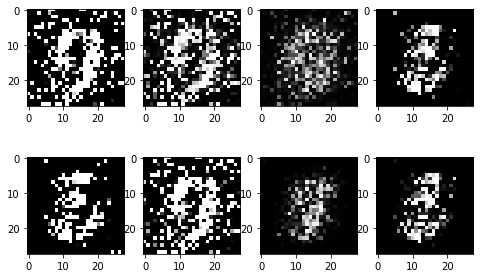

In [ ]:
test_plot(num_test_samples=8,plot_axis=(4,2),generator=generator,latent_dim=latent_dim)

-  If you set n_epochs = 200, you can get the following clean results:

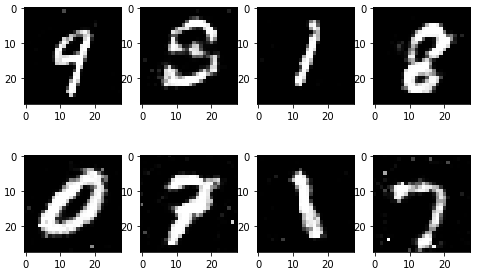

- Plot generator loss and discriminator loss for tracking

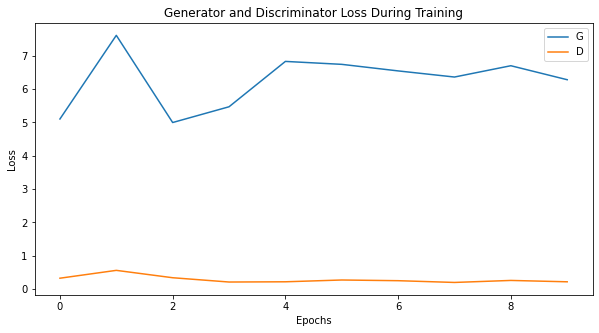

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

- The loss tracking plot for n_epochs=200 is:
  - It can be seen that the difference between the two loss decreases as the epoch passes.
  - However, the disappearance of the difference does not guarantee GAN's performance. Studies on the evaluation criteria for measuring GAN performance are still ongoing research topics.


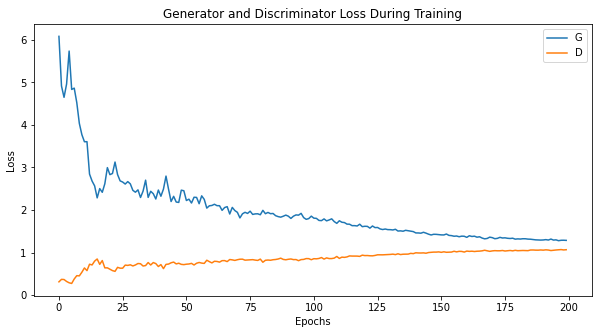

## **Task 2: MNIST image generation with cGAN**


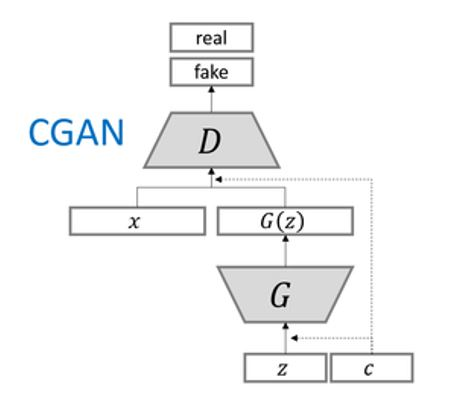

- Conditional generator generates fake images from noise z with randomly chosed labels c.
- Conditional discriminator distinguishes real images and fake images with labels, real images labeled to 1 and fake images labeled to 0.
- In conditional GAN, all modules are composed of multiple fully connected layers.

### **1. Generator module**
- cGAN generator receives the label as input with noise to create the desired image.
- (100,) z input -> Combine after input label embeddedding -> Create (784,) output with full connected layer -> (1,28,28) reshape

In [ ]:
class cGAN_Generator(nn.Module):
    def __init__(self, n_classes=10):
        super(cGAN_Generator, self).__init__()

        self.label_emb = nn.Embedding(10, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, z, labels):
        z = z.view(z.size(0), -1)
        c = self.label_emb(labels).view(z.size(0),-1)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), img_size, img_size)

### **2. Discriminator module**
- cGAN discriminator receives label as input with image to distinguish images corresponding to class
- (784,) Input -> Combine after input label embeddedding -> Generate 0 or 1 prediction with full connected layer

In [ ]:
class cGAN_Discriminator(nn.Module):
    def __init__(self,n_classes=10):
        super(cGAN_Discriminator, self).__init__()

        self.label_emb = nn.Embedding(10, n_classes)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x, labels):
        x = x.view(x.size(0), -1)
        c = self.label_emb(labels.long())
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

### **3. Loss Function and Optimizer**

- From now on, cGAN can also train in the same order, referring to the vanilla GAN above!
- Define Generator / Discrimulator Model
- Setting the Learning rate for Weight training, implement the Loss function
- Define Generator optimizer, Discrimulator optimizer




In [ ]:
cGAN_lr = 0.0002                                                                      # "adam: learning rate"

# Loss functions
cGAN_criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
cGAN_generator = cGAN_Generator()
cGAN_discriminator = cGAN_Discriminator()
cGAN_generator.weight_init(mean=0.0,std=0.02)
cGAN_discriminator.weight_init(mean=0.0,std=0.02)

if cuda:
    cGAN_generator.cuda()
    cGAN_discriminator.cuda()
    cGAN_criterion.cuda()

# Optimizers
cGAN_g_optimizer = torch.optim.Adam(cGAN_generator.parameters(), lr=cGAN_lr)
cGAN_d_optimizer = torch.optim.Adam(cGAN_discriminator.parameters(), lr=cGAN_lr)

### **4. Discriminator train function**
 - To calculate discriminator loss and update parameter during actual training.
 - Same as above except for putting **labels** also as input into the generator and discriminator.

In [ ]:
def cGAN_train_discriminator(cGAN_discriminator, cGAN_generator, images, labels):
    cGAN_d_optimizer.zero_grad()                                                 # initialize parameter to 0

    # real image/label to cuda
    real_images = images.to(device)                                              # real images
    real_labels = labels.to(device)                                              # real labels
    real_labels_output = torch.ones(images.size(0)).to(device)                   # discriminator output of real images(=1)

    # train with real images
    ######################### TASK #######################

    real_validity = cGAN_discriminator(real_images,real_labels)                                         # putting the real images into the discriminator (real=1 or fake=0)
    real_loss = cGAN_criterion(real_validity, real_labels_output)                            # calculate loss by comparing real_validity to real_labels_output (1)
    
    ######################################################

    # fake image/label 생성
    z = torch.randn(images.size(0), latent_dim).to(device)                       # generate noise
    fake_labels = torch.LongTensor(np.random.randint(0, n_classes, images.size(0))).to(device) # fake labels 생성 (random하게 생성)
    fake_images = cGAN_generator(z, fake_labels)                                 # generate a fake image by inserting noise into the generator
    fake_labels_output = torch.zeros(images.size(0)).to(device)                  # discriminator output of fake images(=0)
    
    # train with fake images
    ######################### TASK #######################

    fake_validity = cGAN_discriminator(fake_images,fake_labels)                                                             # putting the fake images into the discriminator
    fake_loss = cGAN_criterion(fake_validity,fake_labels_output)                                                # calculate loss by comparing fake_validity to fake_labels_output (0)
    
    ######################################################

    ######################### TASK #######################
    
    d_loss = real_loss + fake_loss                                                                    # descriminator loss is the sum of two losses
    
    ######################################################
    d_loss.backward()                                                            # backpropagation
    cGAN_d_optimizer.step()                                                      # parameter update
    
    return d_loss.item()


### **5. Generator train function**
- To calculate discriminator loss and update parameter during actual training.
- Same as above except for putting **labels** also as input into the generator and discriminator.

In [ ]:
def cGAN_train_generator(cGAN_discriminator, cGAN_generator, batch_size):
    cGAN_g_optimizer.zero_grad()

    real_labels_output = torch.ones(batch_size).to(device)                       # discriminator output of real images(=1)

    # compute fake validity
    z = torch.randn(batch_size, latent_dim).to(device)                           # generate noise
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device) # generate fake labels randomly 
    fake_images = cGAN_generator(z, fake_labels)                                 # generate a fake image by inserting noise into the generator
    
    ######################### TASK #######################
    
    fake_validity = cGAN_discriminator(fake_images)                              # putting the fake images into the discriminator
    g_loss = cGAN_generator(z,fake_labels)                                                    # calculate loss -> compare the output of discriminator from fake-image to the output(=1) from real-image
    
    ######################################################                                                                              

    g_loss.backward()                                                            # backpropagation
    cGAN_g_optimizer.step()                                                      # parameter update

    return g_loss.item()


### **6. cGAN training**
- Plot the test image to confirm the training result from cGAN.

In [ ]:
def test_plot_cGAN(num_test_samples,plot_axis,generator,latent_dim):
    (a,b) = plot_axis
    test_noise = torch.randn(num_test_samples, latent_dim).to(device)
    test_labels = torch.LongTensor([i for i in range(n_classes)]).to(device)
    fig,axes = plt.subplots(b,a,figsize=(2*a,2.5*b))

    test_images = generator(test_noise,test_labels)

    for i in range(num_test_samples):
        ax = axes[i//a,i%a]
        ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

    plt.show()

- Same as Vanilla GAN!
- Do disciminator training first and then generator training in each epoch
- Theoretically, it is necessary to train until there is no difference between the generator loss and the discrimulator loss, so we stored two losses in the D_losses&G_losses variables for tracking (saved average loss because there are multiple batches in each epoch)
- It is set to train for 10 epochs only due to class time limit, but it can be set to larger epochs to create clean digit images.

In [ ]:
cGAN_D_losses = []
cGAN_G_losses = []

n_epochs = 10                                                                    # "number of epochs of training"
 
for epoch in tqdm(range(n_epochs)):
    cGAN_d_avg_loss = 0
    cGAN_g_avg_loss = 0

    for n, (images, labels) in enumerate(train_loader):
        ######################### TASK #######################

        d_loss = cGAN_train_discriminator(cGAN_discriminator, cGAN_generator, images,labels)                            # Training Discriminator
        g_loss = cGAN_train_generator(cGAN_discriminator, cGAN_generator, batch_size)                                     # Training Generator

        ######################################################
        
        cGAN_d_avg_loss += d_loss
        cGAN_g_avg_loss += g_loss

    cGAN_d_avg_loss /= len(train_loader)
    cGAN_g_avg_loss /= len(train_loader)
    cGAN_D_losses.append(cGAN_d_avg_loss)
    cGAN_G_losses.append(cGAN_g_avg_loss)

    print('Epoch [%3d/%3d], Step[%3d/%3d], d_loss: %.4f, g_loss: %.4f' 
          %(epoch + 1, n_epochs, n+1, len(train_loader), cGAN_d_avg_loss, cGAN_g_avg_loss))


  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: ignored

- Check the generated images for 10 test samples for each class as a result of training

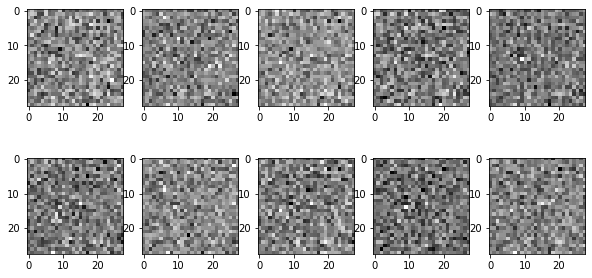

In [ ]:
test_plot_cGAN(num_test_samples=n_classes,plot_axis=(5,2),generator=cGAN_generator,latent_dim=latent_dim)

- If you set large n_epochs = 100, you can get the following clean results:

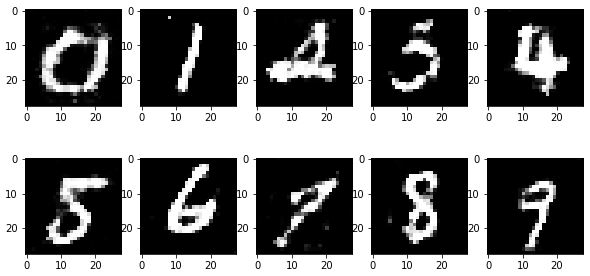

- Plot generator loss and discriminator loss for tracking



In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(cGAN_G_losses,label="G")
plt.plot(cGAN_D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

- The loss tracking plot for n_epochs=100 is:

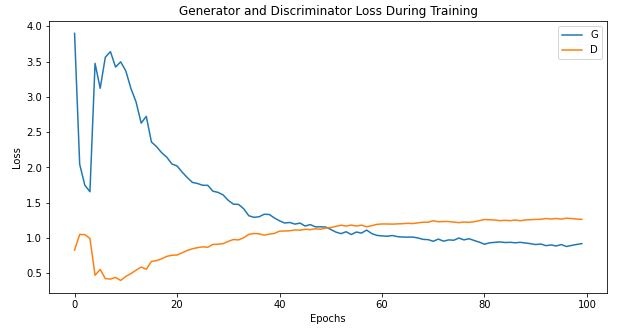

## **Task 3: VAE**


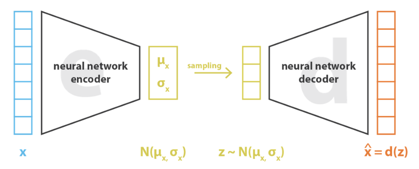



We will see the difference between the distribution of z with and without regularization loss(KL divergence) 

$$ \mathcal{L}\left(\theta, \phi ; \mathbf{x}^{(i)}\right)= - \underbrace{\mathbb{E}_{q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)} \mid \mathbf{z}\right)\right]}_\text{Reconstruction loss} \underbrace{ +{\lambda}D_{K L}\left(q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right) \| p_{\boldsymbol{\theta}}(\mathbf{z})\right)}_\text{Regularization loss} $$

- Assume $ p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)} \mid \mathbf{z}\right) $ is multivariate gaussian.
- $ q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)$ ~ $ \mathcal{N}(\mu_{x}, \sigma_{x})$
- $ p_{\boldsymbol{\theta}}(\mathbf{z}) $ ~ $ \mathcal{N}(0, \mathbf{I})$

### **1. VAE with only Reconstruction loss**



In [ ]:
#Import MNIST datasets with 0 and 6 labels
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

idx =  (train_dataset.targets==0) |  (train_dataset.targets==6)
train_dataset.targets =train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

test_idx =  (test_dataset.targets==0) |  (test_dataset.targets==6)
test_dataset.targets =test_dataset.targets[test_idx]
test_dataset.data = test_dataset.data[test_idx]

In [ ]:
#train_loader
batch_size=32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

In [ ]:
#VAE model
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [ ]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=3)
vae.to(device)

# optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

# return Reconstruction Loss
def loss_function(recon_x, x, mu, log_var):
    Recons_loss = F.mse_loss(recon_x,x.view(-1,784), size_average=False).div(batch_size)
    return Recons_loss

In [ ]:
#VAE train
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

#VAE test
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(0, 20):
    train(epoch)
    test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/11841 (0%)]	Loss: 5.681186
Train Epoch: 0 [3200/11841 (27%)]	Loss: 1.849901
Train Epoch: 0 [6400/11841 (54%)]	Loss: 1.543918
Train Epoch: 0 [9600/11841 (81%)]	Loss: 1.409992
====> Epoch: 0 Average loss: 2.0015
====> Test set loss: 1.3134
Train Epoch: 1 [0/11841 (0%)]	Loss: 1.302563
Train Epoch: 1 [3200/11841 (27%)]	Loss: 1.232385
Train Epoch: 1 [6400/11841 (54%)]	Loss: 1.184344
Train Epoch: 1 [9600/11841 (81%)]	Loss: 1.192466
====> Epoch: 1 Average loss: 1.2106
====> Test set loss: 1.0678
Train Epoch: 2 [0/11841 (0%)]	Loss: 1.033571
Train Epoch: 2 [3200/11841 (27%)]	Loss: 0.966555
Train Epoch: 2 [6400/11841 (54%)]	Loss: 0.970904
Train Epoch: 2 [9600/11841 (81%)]	Loss: 0.999098
====> Epoch: 2 Average loss: 0.9834
====> Test set loss: 0.9190
Train Epoch: 3 [0/11841 (0%)]	Loss: 1.069750
Train Epoch: 3 [3200/11841 (27%)]	Loss: 0.927873
Train Epoch: 3 [6400/11841 (54%)]	Loss: 0.792344
Train Epoch: 3 [9600/11841 (81%)]	Loss: 0.925956
====> Epoch: 3 Average loss: 0.8908
====

We will put each one zero image and six image to encoder, then return $\mu$(mean) and $\sigma^2$(variance) of gaussian posterior.\
To see the change of images according to z, we will change z from $\mu_{0}$ to $\mu_{6}$ and put z to decoder.

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


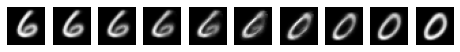

In [ ]:
#change latent to zero to six image

#pick one zero and six image
zero_image = train_dataset.data[train_dataset.targets==0][0].view(-1,784).to(device)
zero_image = zero_image/255.0
six_image = train_dataset.data[train_dataset.targets==6][0].view(-1,784).to(device)
six_image = six_image/255.0

#mean and variance from encoder
zero_z_mu, zero_z_var = vae.encoder(zero_image)
six_z_mu, six_z_var = vae.encoder(six_image)

#pick 10 z's between zero_z_mu and six_z_mu
z_dim=3
z = torch.empty(10,z_dim).to(device)
alpha = np.linspace(0,1,10)
for i in range(10):
  z[i] = alpha[i]*zero_z_mu[0] + (1-alpha[i])*six_z_mu[0]

#images from decoder by z
sample = vae.decoder(z).to(device)
imgs = sample.view(-1,28,28)
imgs = imgs.detach().cpu()

#image plots
fig, axes = plt.subplots(1,10,figsize=(8,8))
ax = axes.ravel()
for i in range(10):
  img = imgs[i]
  ax[i].imshow(img, cmap='gray')
  ax[i].axis('off')
plt.show()

Compare the Gaussian mean distribution(z_$\mu$) when we put 700's zero images and six images to encoder.

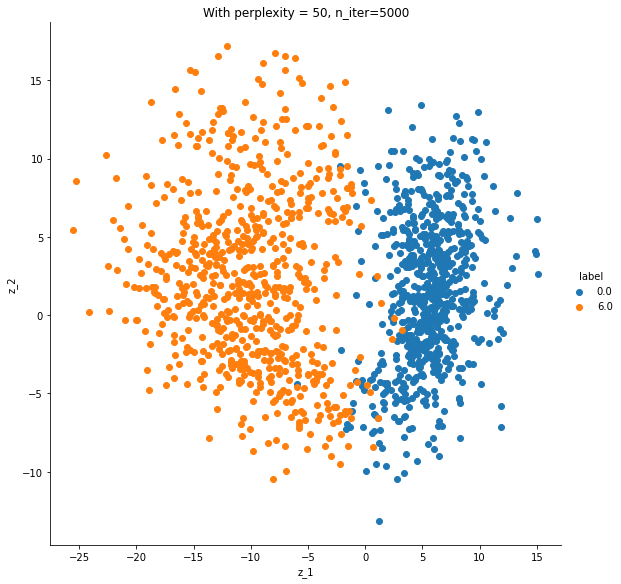

In [ ]:
#we will see the mean of z of 700 zero and six images each
total_z =torch.Tensor()
total_labels = torch.Tensor()

data_size = 700
label = [0,6]
for i in label:
  digit_images = test_dataset.data[test_dataset.targets==i][:data_size].view(-1,784).to(device)
  digit_images = digit_images/255.0

  z_mu, z_var = vae.encoder(digit_images)
  z_mu = z_mu.cpu().detach()

  total_z = torch.cat([total_z, z_mu])
  total_labels = torch.cat([total_labels, torch.ones(data_size)*i])

z1_z2_data = np.vstack((total_z[:,:2].T, total_labels)).T
df = pd.DataFrame(data=z1_z2_data, columns=("z_1", "z_2", "label"))

sn.FacetGrid(df, hue="label", height=8).map(plt.scatter, 'z_1', 'z_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.show()

### **2. VAE with Reconstruction loss and Regularization loss**
- Now, add regularization loss(KL divergence) to make distribution should be similar to a zero-mean unit-variance Gaussian along all dimensions.
- Check the difference with above result. 
- As explained in the lecture note, KLD loss can be computed as follows:
- The regularization loss in the upper equation ($D_{K L}\left(q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right) \| p_{\boldsymbol{\theta}}(\mathbf{z})\right)$)  can be computed as below.
    - As mentioned above, the regularization loss tries to reduce difference between $ q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right) $ and $  p_{\boldsymbol{\theta}}(\mathbf{z}) $.
    - $ q_{\phi}\left(\mathbf{z} \mid \mathbf{x}^{(i)}\right)$ ~ $ \mathcal{N}(\mu_{x}, \sigma_{x})$
    - $ p_{\boldsymbol{\theta}}(\mathbf{z}) $ ~ $ \mathcal{N}(0, \mathbf{I})$
    - $\mu_x, \sigma_x, \mathbf{I}$ have dimension size of $N$.
    - $KLD = \sum_{j=1}^{N} KL{(N(\mu_j, \sigma_j), N(0,1))}\ = \sum_{j=1}^{N} 0.5*[\mu_j^2 + \sigma_j^2 -log(\sigma_j^2)-1]$
    - $N$: dimension of latent space (z)
    - variable log_var: $log(\sigma^2)$
    - **Sum over both batch dimension and data dimension to compute KLD loss.**
    - **Hint) use torch.sum(), which will return single value**
    - Both BCE loss and KLD loss will be divided to batch_size before return to consider sample unit loss.



In [ ]:
#With KL divergence term(Regularization Loss)

# build model
vae_KLD = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=3)
vae_KLD.to(device)

#optimizer
optimizer = optim.Adam(vae_KLD.parameters(), lr=1e-4)

#reture Reconstruction loss + Regularization Loss
def loss_function_with_KLD(recon_x, x, mu, log_var):

    BCE = F.mse_loss(recon_x, x.view(-1, 784), size_average=False)

    ######################### TASK #######################

    KLD = torch.sum(0.5*(mu**2+log_var.exp()-log_var-1))                                                                     # Compute KLD loss

    ######################################################

    Lambda = 1
    return (BCE + Lambda*KLD)/batch_size

In [ ]:
# vae_KLD train
def train_KLD(epoch):
    vae_KLD.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae_KLD(data)
        loss = loss_function_with_KLD(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

# vae_KLD test
def test_KLD():
    vae_KLD.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae_KLD(data)
            
            # sum up batch loss
            test_loss += loss_function_with_KLD(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(0, 20):
    train_KLD(epoch)
    test_KLD()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [0/60000 (0%)]	Loss: 11.682231
Train Epoch: 0 [12800/60000 (21%)]	Loss: 5.876441
Train Epoch: 0 [25600/60000 (43%)]	Loss: 5.758138
Train Epoch: 0 [38400/60000 (64%)]	Loss: 5.720501
Train Epoch: 0 [51200/60000 (85%)]	Loss: 5.703251
====> Epoch: 0 Average loss: 6.1322
====> Test set loss: 0.7638
Train Epoch: 1 [0/60000 (0%)]	Loss: 5.685267
Train Epoch: 1 [12800/60000 (21%)]	Loss: 5.682365
Train Epoch: 1 [25600/60000 (43%)]	Loss: 5.670890
Train Epoch: 1 [38400/60000 (64%)]	Loss: 5.673489
Train Epoch: 1 [51200/60000 (85%)]	Loss: 5.659425
====> Epoch: 1 Average loss: 5.6758
====> Test set loss: 0.8030
Train Epoch: 2 [0/60000 (0%)]	Loss: 5.654212
Train Epoch: 2 [12800/60000 (21%)]	Loss: 5.657378
Train Epoch: 2 [25600/60000 (43%)]	Loss: 5.671875
Train Epoch: 2 [38400/60000 (64%)]	Loss: 5.648095
Train Epoch: 2 [51200/60000 (85%)]	Loss: 5.660607
====> Epoch: 2 Average loss: 5.6572
====> Test set loss: 0.8023
Train Epoch: 3 [0/60000 (0%)]	Loss: 5.642307
Train Epoch: 3 [12800/60000

In [ ]:
#change latent to zero to six image

#pick one zero and six image
zero_image = train_dataset.data[train_dataset.targets==0][0].view(-1,784).to(device)
zero_image = zero_image/255.0
six_image = train_dataset.data[train_dataset.targets==6][0].view(-1,784).to(device)
six_image = six_image/255.0

#mean and variance from encoder
#same as vae without vae_KLD
zero_z_mu, zero_z_var = vae_KLD.encoder(zero_image)
six_z_mu, six_z_var = vae_KLD.encoder(six_image)

#pick 10 z's between zero_z_mu and six_z_mu
z_dim=3
z = torch.empty(10,z_dim).to(device)
alpha = np.linspace(0,1,10)
for i in range(10):
  z[i] = alpha[i]*zero_z_mu[0] + (1-alpha[i])*six_z_mu[0]

#images from decoder by z
sample = vae_KLD.decoder(z).to(device)
imgs = sample.view(-1,28,28)
imgs = imgs.detach().cpu()

#image plots
fig, axes = plt.subplots(1,10,figsize=(8,8))
ax = axes.ravel()
for i in range(10):
  img = imgs[i]
  ax[i].imshow(img, cmap='gray')
  ax[i].axis('off')
plt.show()

In [ ]:
#we will see the mean of z of 700 zero and six images each

total_z =torch.Tensor()
total_labels = torch.Tensor()

data_size = 700
label = [0,6]
for i in label:
  digit_images = test_dataset.data[test_dataset.targets==i][:data_size].view(-1,784).to(device)
  digit_images = digit_images/255.0

  z_mu, z_var = vae_KLD.encoder(digit_images)
  z_mu = z_mu.cpu().detach()

  total_z = torch.cat([total_z, z_mu])
  total_labels = torch.cat([total_labels, torch.ones(data_size)*i])

z1_z2_data = np.vstack((total_z[:,:2].T, total_labels)).T
df = pd.DataFrame(data=z1_z2_data, columns=("z_1", "z_2", "label"))

sn.FacetGrid(df, hue="label", height=8).map(plt.scatter, 'z_1', 'z_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

## **(Optional) Task 4: MNIST image generation with cDCGAN**


### **0. Data reload**
- cDCGAN generator receives input in ($2^n$,$2^n$) size for convolution layers. So, we reload MNIST dataset with transform scale to image size of (32,32).

In [ ]:
img_size = 32
num_filters = [512,256,128]

# Data transform with added image scale factor
transform = transforms.Compose([
                                transforms.Resize((img_size,img_size)),          # Image resize for convolution
                                transforms.ToTensor(),                           # data type to tensor
                                transforms.Normalize(mean=(0.5,), std=(0.5,))    # pixel noramlize from (0,1) to (-1,1)
])

mnist_train  = datasets.MNIST(root='data', download=True, train=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
                      
# random MNIST test data image plot
fig,axes = plt.subplots(2,5,figsize=(2*5,2.5*2))

examples = enumerate(train_loader)
_, (ex_data, ex_targets) = next(examples)

for i in range(10):
    ax = axes[i//5,i%5]
    ax.imshow(ex_data[i][0],cmap='gray')
    ax.set_title('Label: {}'.format(ex_targets[i]))

plt.show()

### **1. Generator module**
- cDCGAN generator receives the label as input with noise to create the desired image.
- (100,) z input: image deconvolution with ConvTranspose layers & (10,) label input: label deconvolution with ConvTranspose layers -> Combine image&label features and make (1,32,32) size output with output layers

In [ ]:
class cDCGAN_Generator(nn.Module):
    def __init__(self, input_dim=latent_dim, label_dim=n_classes, num_filters=num_filters, output_dim=1):
        super(cDCGAN_Generator, self).__init__()
        
        # Hidden layers
        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Deconvolutional layer
            if i == 0:
                # For input
                input_deconv = torch.nn.ConvTranspose2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer1.add_module('input_deconv', input_deconv)

                # Initializer
                torch.nn.init.normal_(input_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(input_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer1.add_module('input_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.ReLU())

                # For label
                label_deconv = torch.nn.ConvTranspose2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=1, padding=0)
                self.hidden_layer2.add_module('label_deconv', label_deconv)

                # Initializer
                torch.nn.init.normal_(label_deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(label_deconv.bias, 0.0)

                # Batch normalization
                self.hidden_layer2.add_module('label_bn', torch.nn.BatchNorm2d(int(num_filters[i]/2)))

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.ReLU())
            else:
                deconv = torch.nn.ConvTranspose2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                deconv_name = 'deconv' + str(i + 1)
                self.hidden_layer.add_module(deconv_name, deconv)

                # Initializer
                torch.nn.init.normal_(deconv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(deconv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.ReLU())

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Deconvolutional layer
        out = torch.nn.ConvTranspose2d(num_filters[i], output_dim, kernel_size=4, stride=2, padding=1)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Tanh())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out


### **2. Discriminator module**
- cDCGAN discriminator receives the label as input with image to create the desired output value.
- (1,32,32) image input: image convolution with Conv layers & (10,) label input: label convolution with Conv layers -> Combine image&label features and make value output with output layers
- Target values for output: 0 for fake images, 1 for real images

In [ ]:
class cDCGAN_Discriminator(nn.Module):
    def __init__(self, input_dim=1, label_dim=n_classes, num_filters=num_filters, output_dim=1):
        super(cDCGAN_Discriminator, self).__init__()

        self.hidden_layer1 = torch.nn.Sequential()
        self.hidden_layer2 = torch.nn.Sequential()
        self.hidden_layer = torch.nn.Sequential()
        for i in range(len(num_filters)):
            # Convolutional layer
            if i == 0:
                # For input
                input_conv = torch.nn.Conv2d(input_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer1.add_module('input_conv', input_conv)

                # Initializer
                torch.nn.init.normal_(input_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(input_conv.bias, 0.0)

                # Activation
                self.hidden_layer1.add_module('input_act', torch.nn.LeakyReLU(0.2))

                # For label
                label_conv = torch.nn.Conv2d(label_dim, int(num_filters[i]/2), kernel_size=4, stride=2, padding=1)
                self.hidden_layer2.add_module('label_conv', label_conv)

                # Initializer
                torch.nn.init.normal_(label_conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(label_conv.bias, 0.0)

                # Activation
                self.hidden_layer2.add_module('label_act', torch.nn.LeakyReLU(0.2))
            else:
                conv = torch.nn.Conv2d(num_filters[i-1], num_filters[i], kernel_size=4, stride=2, padding=1)

                conv_name = 'conv' + str(i + 1)
                self.hidden_layer.add_module(conv_name, conv)

                # Initializer
                torch.nn.init.normal_(conv.weight, mean=0.0, std=0.02)
                torch.nn.init.constant_(conv.bias, 0.0)

                # Batch normalization
                bn_name = 'bn' + str(i + 1)
                self.hidden_layer.add_module(bn_name, torch.nn.BatchNorm2d(num_filters[i]))

                # Activation
                act_name = 'act' + str(i + 1)
                self.hidden_layer.add_module(act_name, torch.nn.LeakyReLU(0.2))

        # Output layer
        self.output_layer = torch.nn.Sequential()
        # Convolutional layer
        out = torch.nn.Conv2d(num_filters[i], output_dim, kernel_size=4, stride=1, padding=0)
        self.output_layer.add_module('out', out)
        # Initializer
        torch.nn.init.normal_(out.weight, mean=0.0, std=0.02)
        torch.nn.init.constant_(out.bias, 0.0)
        # Activation
        self.output_layer.add_module('act', torch.nn.Sigmoid())

    def forward(self, z, c):
        h1 = self.hidden_layer1(z)
        h2 = self.hidden_layer2(c)
        x = torch.cat([h1, h2], 1)
        h = self.hidden_layer(x)
        out = self.output_layer(h)
        return out.squeeze()

### **3. Loss Function and Optimizer**
- From now on, cDCGAN can also train in the same order, referring to the vanilla GAN&cGAN above!
- Define Generator / Discrimulator Model
- Setting the Learning rate for Weight training, implement the Loss function
- Define Generator optimizer, Discrimulator optimizer


In [ ]:
cDCGAN_lr = 0.0002                                                                      # "adam: learning rate"

# Loss functions
cDCGAN_criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
cDCGAN_generator = cDCGAN_Generator()
cDCGAN_discriminator = cDCGAN_Discriminator()

if cuda:
    cDCGAN_generator.cuda()
    cDCGAN_discriminator.cuda()
    cDCGAN_criterion.cuda()

# Optimizers
cDCGAN_g_optimizer = torch.optim.Adam(cDCGAN_generator.parameters(), lr=cDCGAN_lr)
cDCGAN_d_optimizer = torch.optim.Adam(cDCGAN_discriminator.parameters(), lr=cDCGAN_lr)

### **4. Discriminator train function**
 - To calculate discriminator loss and update parameter during actual training.
 - Same as above! Don't forget to put **labels** also as input into the generator and discriminator since it is conditional model.
 - While training discriminator, generator variables are fixed.

In [ ]:
def cDCGAN_train_discriminator(cDCGAN_discriminator, cDCGAN_generator, images, labels, onehot, fill):
    cDCGAN_d_optimizer.zero_grad()                                               # Initialize parameters to 0

    # real image/label to cuda
    real_images = images.cuda()                                                  # real images
    real_labels = fill[labels].cuda()                                            # real labels
    real_labels_output = torch.ones(images.size(0)).cuda()                       # generate real image discriminator output target values (1)

    # train with real images
    real_validity = cDCGAN_discriminator(real_images, real_labels)               # compute real image validity (discrimnator output)
    real_loss = cDCGAN_criterion(real_validity, real_labels_output).cuda()       # compute real loss (compare output with 1)
    
    # generate fake image/label
    z = torch.randn(images.size(0), latent_dim).view(-1, latent_dim, 1, 1).cuda()  # generate noise
    fake_labels = torch.LongTensor(np.random.randint(0, 10, images.size(0)))     # generate fake labels as random values
    fake_labels_gen = onehot[fake_labels].cuda()
    fake_images = cDCGAN_generator(z, fake_labels_gen)                           # generate fake images with noise through generator
    fake_labels_output = torch.zeros(images.size(0)).cuda()                      # generate fake image discriminator output target values (0)
    
    # train with fake images
    fake_labels_dis =fill[fake_labels].cuda()
    fake_validity = cDCGAN_discriminator(fake_images, fake_labels_dis)           # compute fake image validity (discrimnator output)
    fake_loss = cDCGAN_criterion(fake_validity, fake_labels_output).cuda()       # compute fake loss (compare output with 0)
    
    d_loss = real_loss + fake_loss                                               # add real loss and fake loss which is discriminator loss
    d_loss.backward()                                                            # backpropagation
    cDCGAN_d_optimizer.step()                                                    # parameter update
    
    return d_loss.item()

### **5. Generator train function**
- To calculate discriminator loss and update parameter during actual training.
- Same as above! Don't forget to put **labels** also as input into the generator and discriminator since it is conditional model.
- While training generator, discriminator variables are fixed.

In [ ]:
def cDCGAN_train_generator(cDCGAN_discriminator, cDCGAN_generator, batch_size, onehot, fill):
    cDCGAN_g_optimizer.zero_grad()

    real_labels_output =torch.ones(batch_size).cuda()                            # generate real image discriminator output target values (1)

    # compute fake validity
    z = torch.randn(batch_size, latent_dim).view(-1, latent_dim, 1, 1).cuda()    # generate noise
    fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size))         # generate fake labels as random values
    fake_labels_gen = onehot[fake_labels].cuda()
    fake_images = cDCGAN_generator(z, fake_labels_gen)                           # generate fake images with noise through generator
    fake_labels_dis = fill[fake_labels].cuda()
    fake_validity = cDCGAN_discriminator(fake_images, fake_labels_dis)           # compute fake image validity (discrimnator output)

    g_loss = cDCGAN_criterion(fake_validity, real_labels_output)                 # compute loss -> compare discriminator output of fake images and
                                                                                 # real image expected target values (1)

    g_loss.backward()                                                            # backpropagation
    cDCGAN_g_optimizer.step()                                                    # parameter update

    return g_loss.item()

### **6. cDCGAN training**
- Plot the test image to confirm the training result from cDCGAN.


In [ ]:
def test_plot_cDCGAN(num_test_samples,plot_axis,generator,latent_dim,onehot):
    (a,b) = plot_axis
    test_noise = torch.randn(num_test_samples, latent_dim).view(-1, latent_dim, 1, 1).cuda()
    test_labels = torch.LongTensor([i for i in range(n_classes)]).cuda()
    fig,axes = plt.subplots(b,a,figsize=(2*a,2.5*b))

    test_images = generator(test_noise,onehot[test_labels].cuda())

    for i in range(num_test_samples):
        ax = axes[i//a,i%a]
        ax.imshow(test_images[i,:].data.cpu().numpy().reshape(img_size, img_size),cmap='gray')

    plt.show()

- Same as Vanilla GAN or cGAN!
- Do disciminator training first and then generator training in each epoch
- Theoretically, it is necessary to train until there is no difference between the generator loss and the discrimulator loss, so we stored two losses in the D_losses&G_losses variables for tracking (saved average loss because there are multiple batches in each epoch)
- It is set to train for 2 epochs only due to class time limit, but it can be set to larger epochs to create clean digit images.

In [ ]:
cDCGAN_D_losses = []
cDCGAN_G_losses = []

n_epochs = 2                                                                     # "number of epochs of training"

#label preprocess
onehot = torch.zeros(n_classes, n_classes)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(n_classes,1), 1).view(n_classes, n_classes, 1, 1)
fill = torch.zeros([n_classes, n_classes, img_size, img_size])
for i in range(n_classes):
    fill[i, i, :, :] = 1

for epoch in range(n_epochs):
    cDCGAN_d_avg_loss = 0
    cDCGAN_g_avg_loss = 0

    for n, (images, labels) in enumerate(train_loader):
        d_loss = cDCGAN_train_discriminator(cDCGAN_discriminator, cDCGAN_generator, images, labels, onehot, fill)     # Train discriminator
        g_loss = cDCGAN_train_generator(cDCGAN_discriminator, cDCGAN_generator, batch_size, onehot, fill)             # Train generator

        cDCGAN_d_avg_loss += d_loss
        cDCGAN_g_avg_loss += g_loss

    cDCGAN_d_avg_loss /= len(train_loader)
    cDCGAN_g_avg_loss /= len(train_loader)
    cDCGAN_D_losses.append(cDCGAN_d_avg_loss)
    cDCGAN_G_losses.append(cDCGAN_g_avg_loss)

    print('Epoch [%3d/%3d], Step[%3d/%3d], d_loss: %.4f, g_loss: %.4f' 
          %(epoch + 1, n_epochs, n+1, len(train_loader), cDCGAN_d_avg_loss, cDCGAN_g_avg_loss))

- Check the generated images for 10 test samples for each class as a result of training

In [ ]:
test_plot_cDCGAN(num_test_samples=n_classes,plot_axis=(5,2),generator=cDCGAN_generator,latent_dim=latent_dim,onehot=onehot)

- If you set large n_epochs = 40, you can get the following clean results:

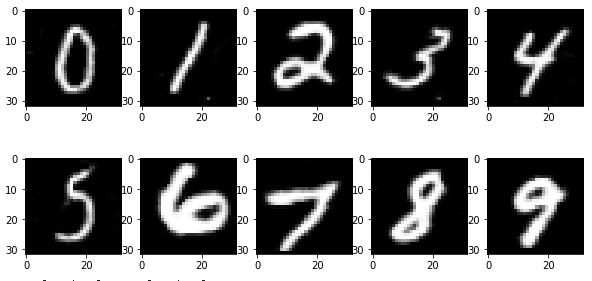

- Plot generator loss and discriminator loss for tracking

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")

plt.plot(cDCGAN_G_losses,label="G")
plt.plot(cDCGAN_D_losses,label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

- The loss tracking plot for n_epochs=40 is:
    - The loss plot unlike above, didn't show convergence to each other, but the generated digit images are clean as shown above.
    - We can emphasize again here, GAN performance evaluation can be done from multiple metrics, besides from plotting losses.

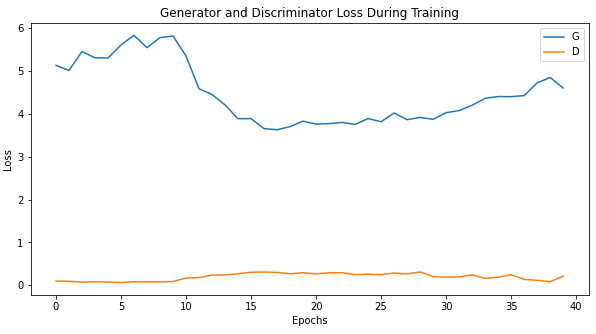

*** Reference ***

1. https://subinium.github.io/VanillaGAN/
2. https://github.com/YBIGTA/Deep_learning/blob/master/GAN/2017-07-29-GAN-tutorial-2-MNIST.markdown
3. https://github.com/arturml/mnist-cgan/blob/master/mnist-cgan.ipynb
4. https://kangbk0120.github.io/articles/2017-08/condgan-imple
5. https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb
6. https://github.com/matthew-liu/beta-vae/blob/master/models.py
7. https://kangbk0120.github.io/articles/2017-08/condgan-imple
8. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
9. https://github.com/togheppi/cDCGAN